In [2]:
#import dependencies
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st
import datetime as dt
from pprint import pprint
import numpy as np
from scipy.stats import linregress

#Resource Files
Aphia_csv = 'Resources/Aphia_Stock_History.csv'
Aurora_csv = 'Resources/Aurora_Stock_History.csv'
Canopy_csv = 'Resources/Canopy_Stock_History.csv'
Bitcoin_csv = 'Resources/Bitcoin_Price_History.csv'
Market_csv = 'Resources/Equal_Weight_Index_History.csv'

#create starting data frames
# Read the mouse data and the study results
Aphia_df = pd.read_csv(Aphia_csv)
Aurora_df = pd.read_csv(Aurora_csv)
Canopy_df = pd.read_csv(Canopy_csv)

Bitcoin_df = pd.read_csv(Bitcoin_csv)
Bitcoin_df.sort_values(by=['Date'], ascending=True)

Market_df = pd.read_csv(Market_csv)
Market_df.head()




,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-02-11,67.910004,68.519997,67.349998,68.089996,62.669830,2591000
1,2016-02-12,68.709999,69.580002,68.370003,69.570000,64.032013,1333900
2,2016-02-16,70.260002,70.959999,69.940002,70.959999,65.311386,1481000
3,2016-02-17,71.440002,72.459999,71.440002,72.269997,66.517097,880600
4,2016-02-18,72.360001,72.360001,71.809998,72.120003,66.379044,1129400


In [3]:
#Convert Date column to Date format, drop excess columns, and remove data prior to 1/1/2014 from Bitcoin file
Bitcoin_df['Date'] = pd.to_datetime(Bitcoin_df['Date'])
#Get rid of the $ and , in the price column so we can convert to float
Bitcoin_df['Price'] = Bitcoin_df['Price'].str.replace('$','')
Bitcoin_df['Price'] = Bitcoin_df['Price'].str.replace(',','')
#Convert to float
Bitcoin_df['Price'] = Bitcoin_df['Price'].astype('float')

Bitcoin_df = Bitcoin_df[Bitcoin_df['Date'] > '2013-12-31']

Aphia_df['Date'] = pd.to_datetime(Aphia_df['Date'])
Aphia_df = Aphia_df.drop(Aphia_df.columns[[1,2,3,5]], axis = 1)

Aurora_df['Date'] = pd.to_datetime(Aurora_df['Date'])
Aurora_df = Aurora_df.drop(Aurora_df.columns[[1,2,3,5]], axis = 1)

Canopy_df['Date'] = pd.to_datetime(Canopy_df['Date'])
Canopy_df = Canopy_df.drop(Canopy_df.columns[[1,2,3,5]], axis = 1)
Bitcoin_df

,Date,Price,Volume,Change
1258,2014-01-01,857.0,1.082691e+07,4.78%
1259,2014-01-02,884.0,8.409629e+06,3.09%
1260,2014-01-03,925.0,1.278463e+07,4.37%
1261,2014-01-04,1015.0,2.078936e+07,8.87%
1262,2014-01-05,1013.0,2.362224e+07,-0.21%
...,...,...,...,...
3845,2021-01-31,33536.0,1.623291e+09,1.17%
3846,2021-02-01,35524.0,1.789699e+09,5.60%
3847,2021-02-02,37677.0,2.340630e+09,5.71%
3848,2021-02-03,36983.0,2.767003e+09,-1.88%


In [4]:
#merge all the dataframes together
merged_df = Bitcoin_df.merge(Aphia_df, how= 'outer', on='Date', suffixes=('_BC','_Aphia'))
merged_df.rename(columns={'Price':'Price_BC','Change':'Change_BC','Close':'Price_Aphia'}, inplace=True)
merged_df = merged_df.merge(Aurora_df, how= 'outer', on='Date', suffixes=('','_Aurora'))
merged_df.rename(columns={'Close':'Price_Aurora','Volume':'Volume_Aurora'}, inplace=True)
merged_df = merged_df.merge(Canopy_df, how= 'outer', on='Date', suffixes=('','_Canopy'))
merged_df.rename(columns={'Close':'Price_Canopy','Volume':'Volume_Canopy'}, inplace=True)

#remove where there are null prices so using same timeframes for all
merged_df = merged_df.dropna(axis=0)
merged_df.head(10)



,Date,Price_BC,Volume_BC,Change_BC,Price_Aphia,Volume_Aphia,Price_Aurora,Volume_Aurora,Price_Canopy,Volume_Canopy
441,2015-03-18,261.0,46525087.0,1.92%,0.719,19700.0,3.396,0.0,1.583,300.0
442,2015-03-19,262.0,13853176.0,0.32%,0.720,0.0,3.396,0.0,1.638,2400.0
443,2015-03-20,260.0,13413361.0,-0.80%,0.725,200.0,3.576,208.0,1.680,1800.0
446,2015-03-23,247.0,38033136.0,-7.60%,0.730,0.0,3.576,25.0,1.689,1300.0
447,2015-03-24,246.0,32092197.0,-0.14%,0.730,0.0,3.516,58.0,1.621,7000.0
448,2015-03-25,248.0,22412560.0,0.67%,0.730,0.0,3.516,0.0,1.627,3300.0
449,2015-03-26,247.0,15543779.0,-0.33%,0.730,0.0,3.516,0.0,1.624,2300.0
450,2015-03-27,252.0,13890989.0,1.91%,0.730,0.0,3.516,0.0,1.647,6600.0
453,2015-03-30,244.0,18515676.0,-1.08%,0.730,0.0,3.528,1292.0,1.635,3400.0
454,2015-03-31,246.0,16412526.0,0.85%,0.730,0.0,3.528,0.0,1.645,2500.0


In [5]:
#Adding the Percent Change by day
merged_df['Returns_BC'] = merged_df['Price_BC'].pct_change(1, fill_method = 'ffill')
merged_df['Returns_Aphia'] = merged_df['Price_Aphia'].pct_change(1, fill_method='ffill')
merged_df['Returns_Aurora'] =merged_df['Price_Aurora'].pct_change(1, fill_method='ffill')
merged_df['Returns_Canopy'] = merged_df['Price_Canopy'].pct_change(1, fill_method='ffill')
merged_df.head(10)

,Date,Price_BC,Volume_BC,Change_BC,Price_Aphia,Volume_Aphia,Price_Aurora,Volume_Aurora,Price_Canopy,Volume_Canopy,Returns_BC,Returns_Aphia,Returns_Aurora,Returns_Canopy
441,2015-03-18,261.0,46525087.0,1.92%,0.719,19700.0,3.396,0.0,1.583,300.0,NaN,NaN,NaN,NaN
442,2015-03-19,262.0,13853176.0,0.32%,0.720,0.0,3.396,0.0,1.638,2400.0,0.003831,0.001391,0.000000,0.034744
443,2015-03-20,260.0,13413361.0,-0.80%,0.725,200.0,3.576,208.0,1.680,1800.0,-0.007634,0.006944,0.053004,0.025641
446,2015-03-23,247.0,38033136.0,-7.60%,0.730,0.0,3.576,25.0,1.689,1300.0,-0.050000,0.006897,0.000000,0.005357
447,2015-03-24,246.0,32092197.0,-0.14%,0.730,0.0,3.516,58.0,1.621,7000.0,-0.004049,0.000000,-0.016779,-0.040261
448,2015-03-25,248.0,22412560.0,0.67%,0.730,0.0,3.516,0.0,1.627,3300.0,0.008130,0.000000,0.000000,0.003701
449,2015-03-26,247.0,15543779.0,-0.33%,0.730,0.0,3.516,0.0,1.624,2300.0,-0.004032,0.000000,0.000000,-0.001844
450,2015-03-27,252.0,13890989.0,1.91%,0.730,0.0,3.516,0.0,1.647,6600.0,0.020243,0.000000,0.000000,0.014163
453,2015-03-30,244.0,18515676.0,-1.08%,0.730,0.0,3.528,1292.0,1.635,3400.0,-0.031746,0.000000,0.003413,-0.007286
454,2015-03-31,246.0,16412526.0,0.85%,0.730,0.0,3.528,0.0,1.645,2500.0,0.008197,0.000000,0.000000,0.006116


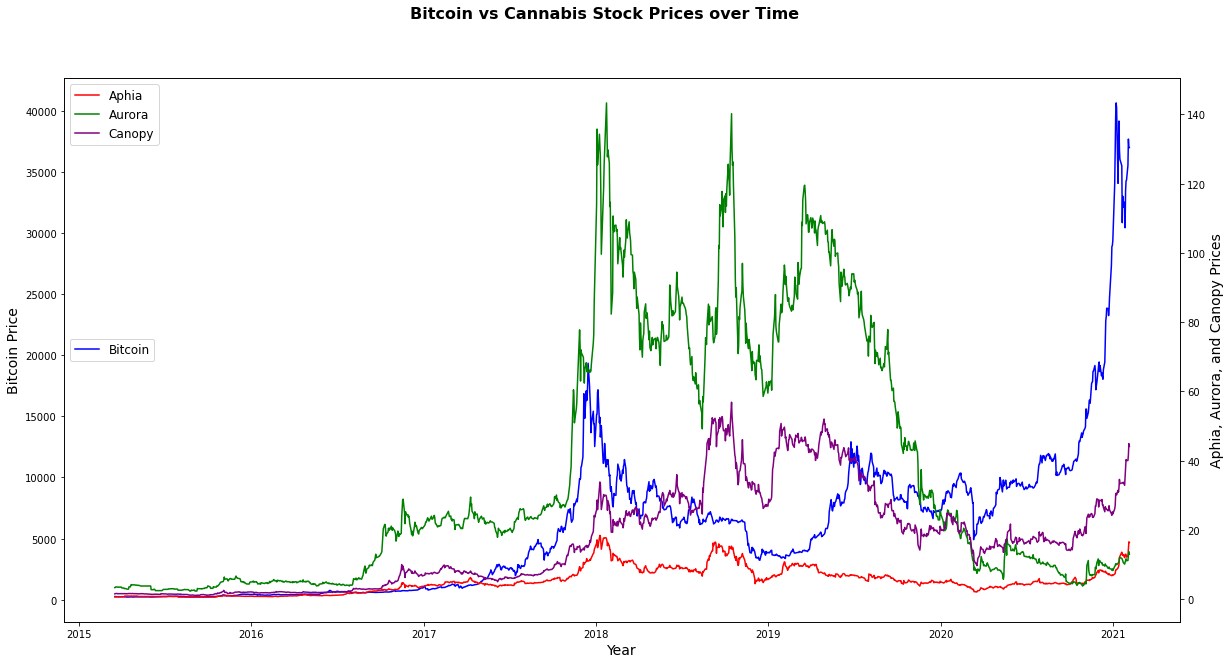

In [18]:
#Plot the prices of Bitcoin and the 3 stocks together
fig,ax = plt.subplots(figsize=(20,10))
#plot Bitcoin Price
ax.plot(merged_df.Date,merged_df.Price_BC, color='blue',label = 'Bitcoin')
ax.set_xlabel("Year",fontsize=14)
ax.set_ylabel("Bitcoin Price", color = 'black',fontsize=14)
plt.legend(loc=6, fontsize = 'large')

ax2=ax.twinx()
ax2.plot(merged_df.Date, merged_df.Price_Aphia, color='red', label = 'Aphia')
ax2.plot(merged_df.Date, merged_df.Price_Aurora, color='green', label = 'Aurora')
ax2.plot(merged_df.Date, merged_df.Price_Canopy, color='purple', label = 'Canopy')
ax2.set_ylabel('Aphia, Aurora, and Canopy Prices', color = 'black',fontsize=14)

fig.suptitle('Bitcoin vs Cannabis Stock Prices over Time', fontsize=16, fontweight='bold')
plt.legend(loc=2, fontsize = 'large')
plt.show()



In [7]:
#Get Pearson values between the prices Bitcoin and all stocks
merged_price = merged_df[['Price_BC', 'Price_Aprhia', 'Price_Aurora','Price_Canopy']]
merged_price.corr(method='pearson')

,Price_BC,Price_Aphia,Price_Aurora,Price_Canopy
Price_BC,1.000000,0.568030,0.227181,0.516063
Price_Aphia,0.568030,1.000000,0.825612,0.809770
Price_Aurora,0.227181,0.825612,1.000000,0.821204
Price_Canopy,0.516063,0.809770,0.821204,1.000000


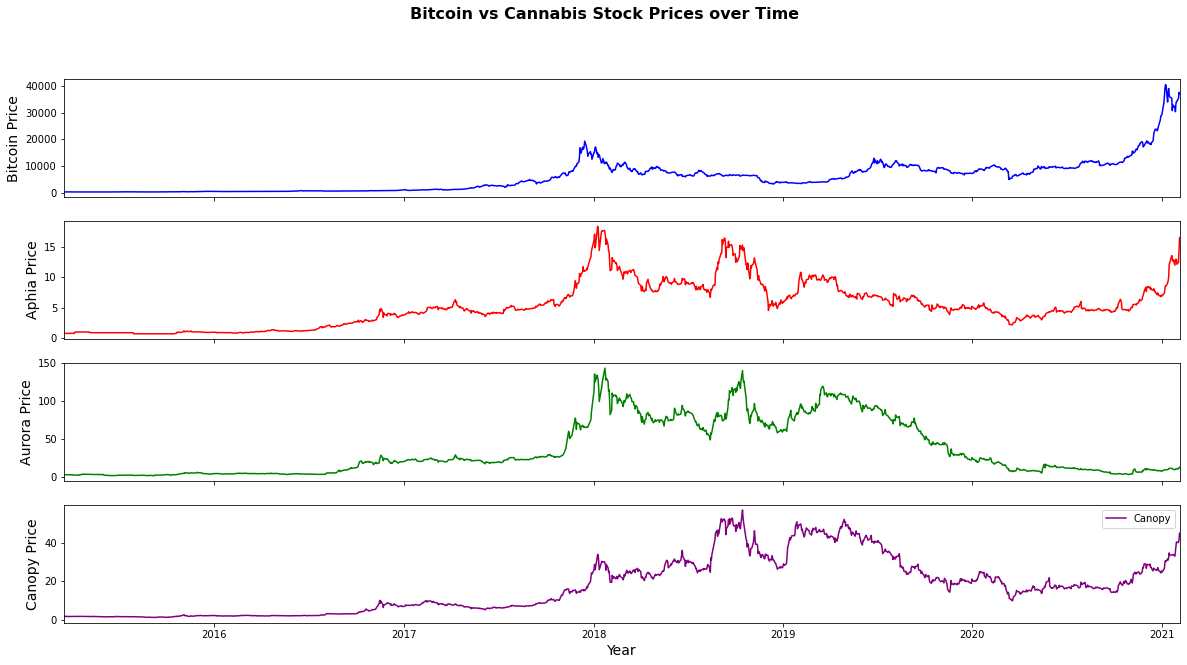

In [20]:
#Subplot of the prices
fig,(ax1, ax2, ax3, ax4) = plt.subplots(4, sharex=True, figsize=(20,10))

fig.suptitle('Bitcoin vs Cannabis Stock Prices over Time', fontsize=16, fontweight='bold')
ax1.set_xlim(min(merged_df.Date), max(merged_df.Date))
ax1.plot(merged_df.Date,merged_df.Price_BC, color='blue', label = 'Bitcoin')
ax1.set_ylabel("Bitcoin Price", color = 'black',fontsize=14)

ax2.plot(merged_df.Date, merged_df.Price_Aphia, color='red', label = 'Aphia')
ax2.set_ylabel("Aphria Price", color = 'black',fontsize=14)


ax3.plot(merged_df.Date, merged_df.Price_Aurora, color='green', label = 'Aurora')
ax3.set_ylabel("Aurora Price", color = 'black',fontsize=14)

ax4.plot(merged_df.Date, merged_df.Price_Canopy, color='purple', label = 'Canopy')
ax4.set_ylabel('Canopy Price', color = 'black',fontsize=14)
ax4.set_xlabel("Year",fontsize=14)


plt.legend()
plt.show()

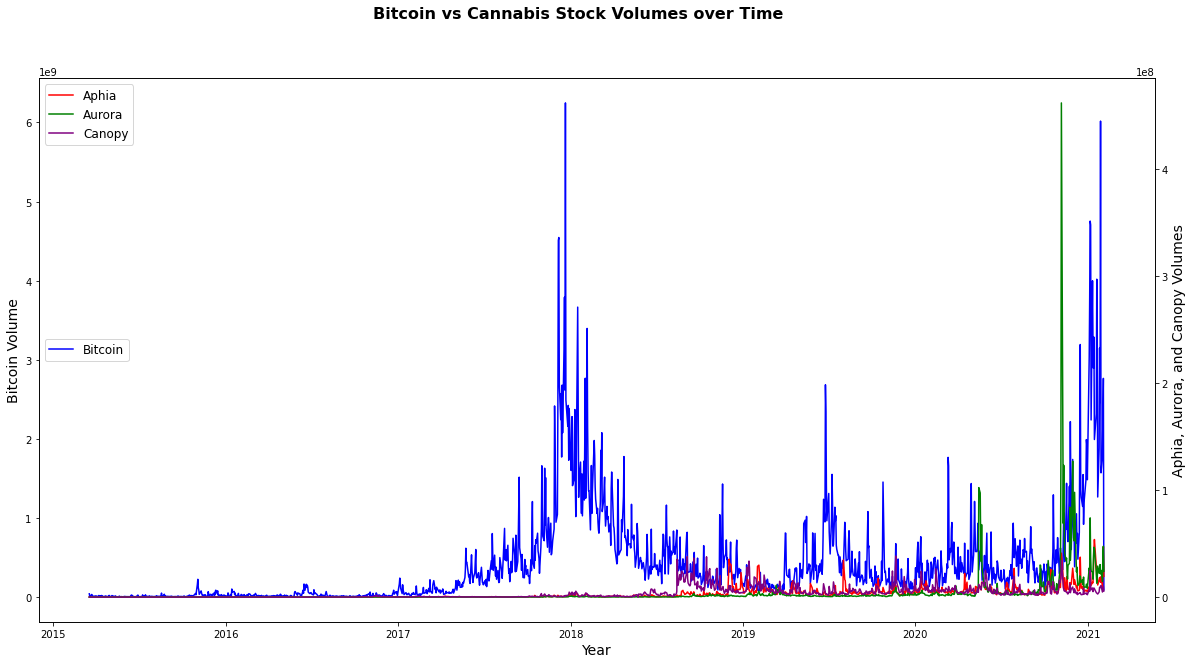

In [22]:
#Plot the volumes of Bitcoin and the 3 stocks together
fig,ax = plt.subplots(figsize=(20,10))
#plot Bitcoin Price
ax.plot(merged_df.Date,merged_df.Volume_BC, color='blue',label = 'Bitcoin')
ax.set_xlabel("Year",fontsize=14)
ax.set_ylabel("Bitcoin Volume", color = 'black',fontsize=14)
plt.legend(loc=6, fontsize = 'large')

ax2=ax.twinx()
ax2.plot(merged_df.Date, merged_df.Volume_Aphia, color='red', label = 'Aphria')
ax2.plot(merged_df.Date, merged_df.Volume_Aurora, color='green', label = 'Aurora')
ax2.plot(merged_df.Date, merged_df.Volume_Canopy, color='purple', label = 'Canopy')
ax2.set_ylabel('Aphia, Aurora, and Canopy Volumes', color = 'black',fontsize=14)

fig.suptitle('Bitcoin vs Cannabis Stock Volumes over Time', fontsize=16, fontweight='bold')
plt.legend(loc=2, fontsize = 'large')
plt.show()

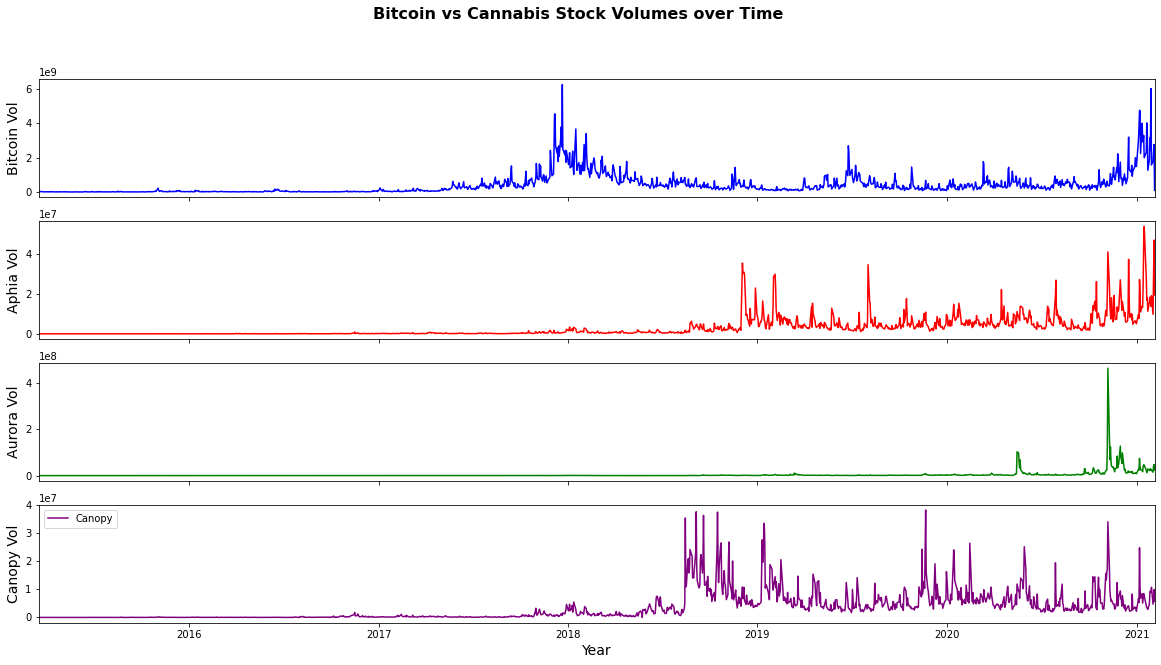

In [8]:
#Plot the volumes of Bitcoin and the 3 stocks together
fig,(ax1, ax2, ax3, ax4) = plt.subplots(4, sharex=True, figsize=(20,10))

fig.suptitle('Bitcoin vs Cannabis Stock Volumes over Time', fontsize=16, fontweight='bold')
ax1.set_xlim(min(merged_df.Date), max(merged_df.Date))
ax1.plot(merged_df.Date,merged_df.Volume_BC, color='blue', label = 'Bitcoin')
ax1.set_ylabel("Bitcoin Vol", color = 'black',fontsize=14)

ax2.plot(merged_df.Date, merged_df.Volume_Aphia, color='red', label = 'Aphia')
ax2.set_ylabel("Aphria Vol", color = 'black',fontsize=14)


ax3.plot(merged_df.Date, merged_df.Volume_Aurora, color='green', label = 'Aurora')
ax3.set_ylabel("Aurora Vol", color = 'black',fontsize=14)

ax4.plot(merged_df.Date, merged_df.Volume_Canopy, color='purple', label = 'Canopy')
ax4.set_ylabel('Canopy Vol', color = 'black',fontsize=14)
ax4.set_xlabel("Year",fontsize=14)


plt.legend()
plt.show()


In [9]:
#Get Pearson values between the Volumes of Bitcoin and all stocks
merged_price = merged_df[['Volume_BC', 'Volume_Aphia', 'Volume_Aurora','Volume_Canopy']]
merged_price.corr(method='pearson')

,Volume_BC,Volume_Aphia,Volume_Aurora,Volume_Canopy
Volume_BC,1.000000,0.320948,0.172282,0.123512
Volume_Aphia,0.320948,1.000000,0.497270,0.492759
Volume_Aurora,0.172282,0.497270,1.000000,0.293051
Volume_Canopy,0.123512,0.492759,0.293051,1.000000


In [45]:
#Looking at a reduced time bound correlations between the subjects
merged_reduced_df = merged_df[merged_df['Date'] >= '2017-01-01' ]
merged_reduced_df.head()

#Get Pearson values between the prices Bitcoin and all stocks
merged_reduced_price = merged_reduced_df[['Price_BC', 'Price_Aphia', 'Price_Aurora','Price_Canopy']]
merged_reduced_price.corr(method='pearson')

,Price_BC,Price_Aphia,Price_Aurora,Price_Canopy
Price_BC,1.000000,0.282529,-0.135283,0.204889
Price_Aphia,0.282529,1.000000,0.739532,0.642032
Price_Aurora,-0.135283,0.739532,1.000000,0.730938
Price_Canopy,0.204889,0.642032,0.730938,1.000000


In [11]:
#Looking at correlations between Bitcoin and the market on the whole, represented by ETF RSP, and Equal Weight S&P 500 ETF
Market_df['Date'] = pd.to_datetime(Market_df['Date'])
Market_df = Market_df.drop(Market_df.columns[[1,2,3,5]], axis = 1)
Market_df



,Date,Close,Volume
0,2016-02-11,68.089996,2591000
1,2016-02-12,69.570000,1333900
2,2016-02-16,70.959999,1481000
3,2016-02-17,72.269997,880600
4,2016-02-18,72.120003,1129400
...,...,...,...
1254,2021-02-04,131.869995,1358100
1255,2021-02-05,132.550003,1398200
1256,2021-02-08,134.100006,908200
1257,2021-02-09,134.050003,1483700


In [12]:
#Merge Bitcoin and Overall Market data into one dataframe
BC_Market_df = Bitcoin_df.merge(Market_df, how= 'outer', on='Date', suffixes=('_BC','_Market'))
BC_Market_df.rename(columns={'Price':'Price_BC','Change':'Change_BC','Close':'Price_Market'}, inplace=True)
BC_Market_df =BC_Market_df.dropna(axis=0)
BC_Market_df.head(10)


,Date,Price_BC,Volume_BC,Change_BC,Price_Market,Volume_Market
771,2016-02-11,384.0,20685663.0,1.20%,68.089996,2591000.0
772,2016-02-12,390.0,18757146.0,1.55%,69.570000,1333900.0
776,2016-02-16,417.0,37559686.0,2.57%,70.959999,1481000.0
777,2016-02-17,421.0,32541108.0,1.01%,72.269997,880600.0
778,2016-02-18,420.0,21991481.0,-0.34%,72.120003,1129400.0
779,2016-02-19,440.0,48500794.0,4.56%,71.900002,819400.0
782,2016-02-22,420.0,39915706.0,-4.26%,73.160004,693700.0
783,2016-02-23,423.0,28041200.0,0.67%,72.290001,590500.0
784,2016-02-24,423.0,22692099.0,0.18%,72.720001,1093400.0
785,2016-02-25,427.0,22642014.0,0.90%,73.529999,943200.0


In [13]:
#Get Pearson values between the Volumes of Bitcoin and all stocks
BC_Market_Price = BC_Market_df[['Price_BC', 'Price_Market']]
BC_Market_Price.corr(method='pearson')

,Price_BC,Price_Market
Price_BC,1.00000,0.80374
Price_Market,0.80374,1.00000


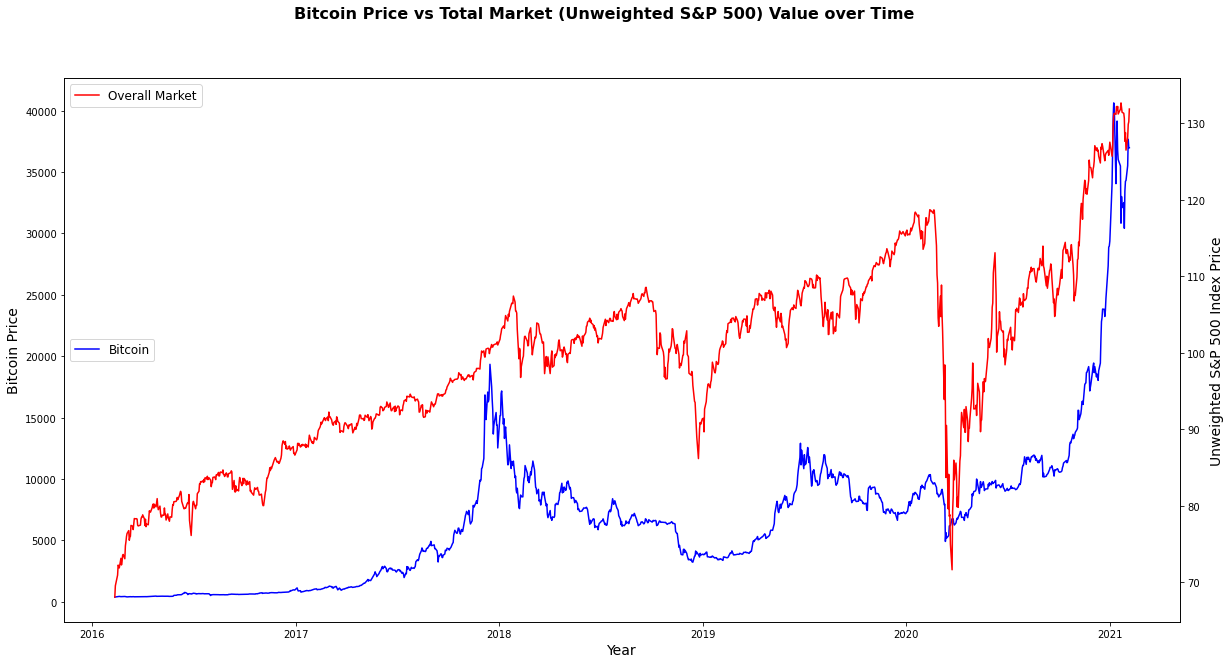

In [16]:
fig,ax = plt.subplots(figsize=(20,10))
#plot Bitcoin Price
ax.plot(BC_Market_df.Date,BC_Market_df.Price_BC, color='blue',label = 'Bitcoin')
ax.set_xlabel("Year",fontsize=14)
ax.set_ylabel("Bitcoin Price", color = 'black',fontsize=14)
plt.legend(loc=6, fontsize = 'large')

ax2=ax.twinx()
ax2.plot(BC_Market_df.Date, BC_Market_df.Price_Market, color='red', label = 'Overall Market')
ax2.set_ylabel('Unweighted S&P 500 Index Price', color = 'black',fontsize=14)
fig.suptitle('Bitcoin Price vs Total Market (Unweighted S&P 500) Value over Time', fontsize=16, fontweight='bold')

plt.legend(loc=2, fontsize = 'large')
plt.show()


In [15]:
#Looking for correlation in returns. 
returns_df = merged_df[merged_df['Date'] >= '2017-01-01' ]


returns = returns_df[['Returns_BC', 'Returns_Aphia', 'Returns_Aurora', 'Returns_Canopy']]
returns.corr(method='pearson')

,Returns_BC,Returns_Aphia,Returns_Aurora,Returns_Canopy
Returns_BC,1.000000,0.019699,0.002083,-0.030711
Returns_Aphia,0.019699,1.000000,0.543799,0.651724
Returns_Aurora,0.002083,0.543799,1.000000,0.634575
Returns_Canopy,-0.030711,0.651724,0.634575,1.000000


In [30]:
Aphia_Max = merged_df.Returns_Aphia.max()
Aphia_Max_Date = merged_df.loc[merged_df['Returns_Aphria']==Aphia_Max, 'Date'].iloc[0]

Aurora_Max = merged_df.Returns_Aurora.max()
Aurora_Max_Date = merged_df.loc[merged_df['Returns_Aurora']==Aurora_Max, 'Date'].iloc[0]

Canopy_Max = merged_df.Returns_Canopy.max()
Canopy_Max_Date = merged_df.loc[merged_df['Returns_Canopy']==Canopy_Max, 'Date'].iloc[0]

print(f'Aphrias best daily return was {Aphia_Max} on {Aphia_Max_Date}')
print(f'Auroras best daily return was {Aurora_Max} on {Aurora_Max_Date}')
print(f'Canopys best daily return was {Canopy_Max} on {Canopy_Max_Date}')

Aphias best daily return was 0.4096153846153845 on 2019-08-02 00:00:00
Auroras best daily return was 0.6867469879518071 on 2020-05-15 00:00:00
Canopys best daily return was 0.30422419560421643 on 2018-08-15 00:00:00


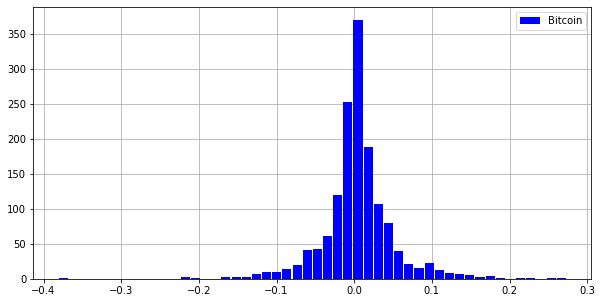

In [44]:
#price histograms

merged_df['Returns_BC'].hist(bins=50, figsize= (10,5), color = 'blue', zorder=2, rwidth=0.9, label='Bitcoin')
#merged_df['Returns_Aphia'].hist(bins=50, figsize= (10,5), color = 'red', zorder=2, rwidth=0.9, label='Aphria')
#merged_df['Returns_Aurora'].hist(bins=50, figsize= (10,5), color = 'green', zorder=2, rwidth=0.9, label='Aurora')
#merged_df['Returns_Canopy'].hist(bins=50, figsize= (10,5), color = 'orange', zorder=2, rwidth=0.9, label='Canopy')
plt.legend()
plt.show()